<a href="https://colab.research.google.com/github/isinghsrishti/grocery-product-detection/blob/main/Colabs/grocery-dataset-eda-prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook prepares the [Grocery Dataset](https://github.com/gulvarol/grocerydataset) to train an object detection model to detect products from a store shelf image. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Gather data sources

In [2]:
!wget -q https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz
!tar xf ShelfImages.tar.gz

In [3]:
!wget -q https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz
!tar xf GroceryDataset_part2.tar.gz

In [4]:
!ls -lh ShelfImages | head -10
!ls -lh ShelfImages/train | head -10
!ls -lh ShelfImages/test | head -10

total 20K
drwxrwxr-x 2 1001 1001 4.0K Sep 14 17:38 test
drwxrwxr-x 2 1001 1001  16K Sep 14 17:38 train
total 456M
-rw-r--r-- 1 1001 1001  645K Oct 23  2019 C1_P01_N1_S2_1.JPG
-rw-r--r-- 1 1001 1001  2.1M Oct 23  2019 C1_P01_N1_S2_2.JPG
-rw-r--r-- 1 1001 1001  1.1M Oct 23  2019 C1_P01_N1_S3_1.JPG
-rw-r--r-- 1 1001 1001  870K Oct 23  2019 C1_P01_N1_S3_2.JPG
-rw-r--r-- 1 1001 1001  907K Oct 23  2019 C1_P01_N1_S5_1.JPG
-rw-r--r-- 1 1001 1001  2.1M Oct 23  2019 C1_P01_N2_S2_1.JPG
-rw-r--r-- 1 1001 1001  1.3M Oct 23  2019 C1_P01_N2_S3_1.JPG
-rw-r--r-- 1 1001 1001  1.1M Oct 23  2019 C1_P01_N2_S4_1.JPG
-rw-r--r-- 1 1001 1001  2.0M Oct 23  2019 C1_P01_N3_S2_1.JPG
total 101M
-rw-r--r-- 1 1001 1001 1.6M Oct 23  2019 C1_P02_N1_S5_1.JPG
-rw-r--r-- 1 1001 1001 2.3M Oct 23  2019 C1_P02_N2_S2_1.JPG
-rw-r--r-- 1 1001 1001 2.3M Oct 23  2019 C1_P02_N2_S3_1.JPG
-rw-r--r-- 1 1001 1001 1.3M Oct 23  2019 C1_P03_N1_S2_1.JPG
-rw-r--r-- 1 1001 1001 1.6M Oct 23  2019 C1_P03_N1_S3_1.JPG
-rw-r--r-- 1 1001 1001 2.4

From [here](https://github.com/gulvarol/grocerydataset#shelfimages) we can get a sense of how an individual image is named:

```
"C<c>_P<p>_N<n>_S<s>_<i>.JPG"
    where
        <c> := camera id (1: iPhone5S, 2: iPhone4, 3: Sony Cybershot, 4: Nikon Coolpix)
        <p> := planogram id
        <n> := the rank of the top shelf on the image according to the planogram
        <s> := number of shelves on the image
        <i> := copy number
```

## Imports

In [5]:
from imutils import paths
from typing import List
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Visualize the raw images

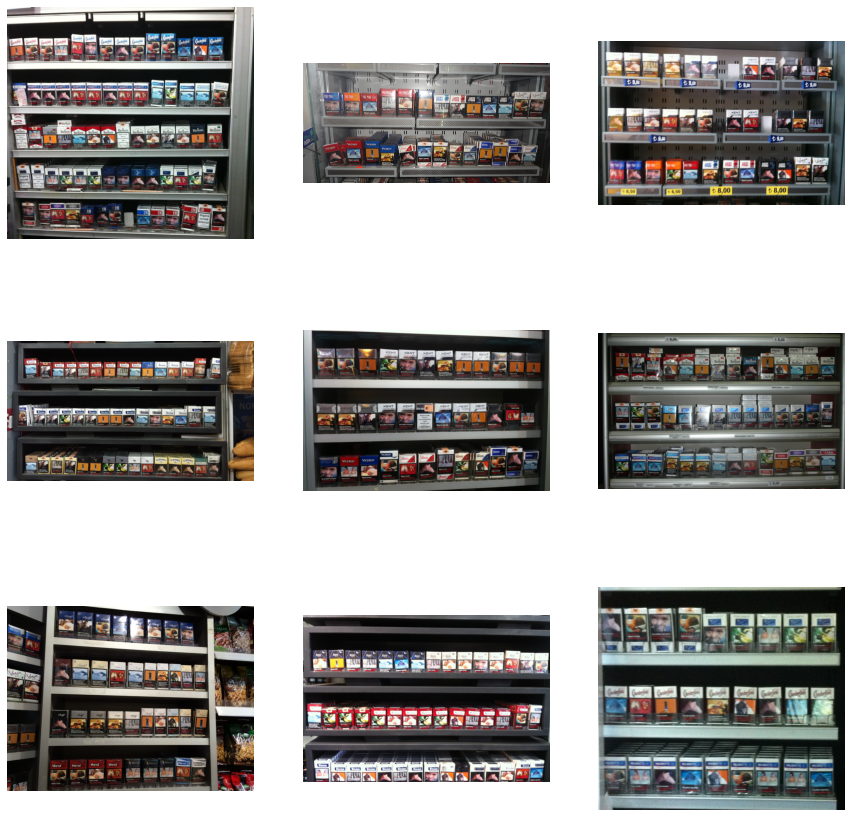

In [6]:
train_images = list(paths.list_images("ShelfImages/train"))
plt.figure(figsize=(15, 15))
for i, image  in enumerate(train_images[:9]):
    image = plt.imread(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

A question that gets raised here - how do I map these images to their detection annotations? From [here](https://github.com/gulvarol/grocerydataset#annotationtxt) we have the following information (which is summarized in [`annotations.csv`](https://github.com/gulvarol/grocerydataset/blob/master/annotations.csv)) - 

```
<shelf image name> <n> <x_1> <y_1> <w_1> <h_1> <b_1> <x_2> <y_2> <w_2> <h_2> <b_2> ... <x_n> <y_n> <w_n> <h_n> <b_n>
    where
        <shelf image name>   := shelf image name
        <n>                  := number of product on the shelf image
        <x_i>                := x-coordinate of the i'th product image
        <y_i>                := y-coordinate of the i'th product image
        <w_i>                := width of the i'th product image
        <h_i>                := height of the i'th product image
        <b_i>                := brand of the i'th product image
```

## Visualize bbox annotations 

In [7]:
cols = ["image_name", "x_i", "y_i", "w_i", "h_i", "b_i"]
master_df = pd.read_csv("https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv", 
                        names=cols)
master_df.head()

,image_name,x_i,y_i,w_i,h_i,b_i
0,C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,0
1,C1_P01_N1_S2_1.JPG,1028,928,1280,1304,0
2,C1_P01_N1_S2_1.JPG,24,872,268,1264,0
3,C1_P01_N1_S2_1.JPG,280,1568,532,1944,0
4,C1_P01_N1_S2_1.JPG,292,872,544,1248,0


In [8]:
# How many unique brands? (0 stands for "other" class)
master_df["b_i"].unique()

array([ 0,  1,  4,  7,  3,  6, 10,  2,  5,  8,  9])

Let's visualize a few images with their respective annotations. We will write a small utility for this purpose. 

In [9]:
def vis_annotations(image_path: str, coordinate_list: List[List[int]], 
                    color: str="blue") -> None:
    """Converts bounding box to matplotlib format, imposes it on the 
    provided image and then displays the plot."""
    image = plt.imread(image_path)
    fig = plt.imshow(image)
    for i in range(len(coordinate_list)):
        bbox = coordinate_list[i]
        fig.axes.add_patch(plt.Rectangle(
            xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
            fill=False, edgecolor=color, linewidth=2))
    plt.show()

Let's start with the first image from the dataframe above. Its absolute path is present in `train_images`.

In [10]:
train_images[0]

'ShelfImages/train/C2_P04_N1_S5_1.JPG'

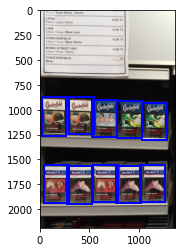

In [11]:
coordinate_columns = master_df.columns[1:-1]
coordinate_list = master_df[master_df["image_name"]=="C1_P01_N1_S2_1.JPG"][coordinate_columns]
coordinate_list = coordinate_list.values.tolist()
vis_annotations("ShelfImages/train/C1_P01_N1_S2_1.JPG", coordinate_list)

## Splitting into train and test dataframes

We already have the train and test images segregated. We can use that information to split `master_df` into train and test dataframes. 

In [12]:
# Grab the image names belonging to the train and test sets
train_images = list(paths.list_images("ShelfImages/train"))
test_images = list(paths.list_images("ShelfImages/test"))
train_image_names = [image_path.split("/")[-1] for image_path in train_images]
test_image_names = [image_path.split("/")[-1] for image_path in test_images]
print(len(train_image_names), len(test_image_names))

283 71


In [13]:
# Create two different dataframes from train and test sets
train_df = master_df[master_df["image_name"].isin(train_image_names)]
test_df = master_df[~master_df["image_name"].isin(train_image_names)]
print(len(np.unique(train_df["image_name"])), len(np.unique(test_df["image_name"])))

283 71


In [14]:
# Let's turn the image names into absolute paths
train_df["image_name"] = train_df["image_name"].map(lambda x: "ShelfImages/train/" + x)
test_df["image_name"] = test_df["image_name"].map(lambda x: "ShelfImages/test/" + x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Preview
train_df.head()

,image_name,x_i,y_i,w_i,h_i,b_i
0,ShelfImages/train/C1_P01_N1_S2_1.JPG,1008,1552,1260,1928,0
1,ShelfImages/train/C1_P01_N1_S2_1.JPG,1028,928,1280,1304,0
2,ShelfImages/train/C1_P01_N1_S2_1.JPG,24,872,268,1264,0
3,ShelfImages/train/C1_P01_N1_S2_1.JPG,280,1568,532,1944,0
4,ShelfImages/train/C1_P01_N1_S2_1.JPG,292,872,544,1248,0


## Setup TFOD API

In [16]:
%tensorflow_version 1.x
import tensorflow as tf 
print(tf.__version__)

!git clone https://github.com/tensorflow/models.git

% cd models/research
!pip install --upgrade pip
# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf1/setup.py .
!python -m pip install --use-feature=2020-resolver .

TensorFlow 1.x selected.
1.15.2
Cloning into 'models'...
remote: Enumerating objects: 62498, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 62498 (delta 4), reused 14 (delta 0), pack-reused 62469
Receiving objects: 100% (62498/62498), 574.52 MiB | 29.72 MiB/s, done.
Resolving deltas: 100% (43555/43555), done.
/content/models/research
     |████████████████████████████████| 1.6 MB 6.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https

## Generating TFRecords


In [17]:
def prepare_df(original_df):
    df = pd.DataFrame()
    df["filename"] = original_df["image_name"]
    df["wdith"] = (original_df["x_i"] - original_df["w_i"]).astype("int")
    df["height"] = (original_df["y_i"] - original_df["h_i"]).astype("int")
    df["class"] = (original_df["b_i"] + 1).astype("int")
    df["xmin"] = (original_df["x_i"]).astype("int") 
    df["ymin"] = (original_df["y_i"]).astype("int")
    df["xmax"] = (original_df["w_i"]).astype("int") 
    df["ymax"] = (original_df["h_i"]).astype("int")
    return df

In [18]:
new_train_df = prepare_df(train_df)
new_test_df = prepare_df(test_df)
print(len(np.unique(new_train_df["filename"])), len(np.unique(new_test_df["filename"])))

283 71


In [19]:
# Serialize these dataframes
new_train_df.to_csv("train.csv", index=False)
new_test_df.to_csv("test.csv", index=False)

In [20]:
!ls -lh *.csv

-rw-r--r-- 1 root root 172K Sep 14 17:42 test.csv
-rw-r--r-- 1 root root 693K Sep 14 17:42 train.csv


In [ ]:
# get generate_tfrecord code

In [21]:
pwd

'/content/models/research'

In [22]:
cd ..

/content/models


In [23]:
pwd

'/content/models'

In [25]:
cd ..

/content


In [26]:
pwd

'/content'

In [27]:
!python /content/generate_tfrecord.py \
    --csv_input=/content/models/research/train.csv \
    --output_path=/content/train.record 
!python /content/generate_tfrecord.py \
    --csv_input=/content/models/research/test.csv \
    --output_path=/content/test.record 

!ls -lh *.record



W0914 17:44:23.654412 139743450253184 module_wrapper.py:139] From /content/generate_tfrecord.py:78: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0914 17:44:23.734338 139743450253184 module_wrapper.py:139] From /content/generate_tfrecord.py:37: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/train.record


W0914 17:44:30.721517 139742233683840 module_wrapper.py:139] From /content/generate_tfrecord.py:78: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0914 17:44:30.747103 139742233683840 module_wrapper.py:139] From /content/generate_tfrecord.py:37: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/test.record
-rw-r--r-- 1 root root 101M Sep 14 17:44 test.record
-rw-r--r-- 1 root root 456M Sep 14 17:44 train.record


## Generate `.pbtxt`

We need to generate a `.pbtxt` file that defines a mapping between our classes and integers. In our case, the classes are already integers. But we still need this file for the TFOD API to operate. 

In [28]:
classes = new_train_df["class"].unique()
label_encodings = {}
for cls in classes:
    label_encodings[str(cls)] = int(cls)

f = open("/content/label_map.pbtxt", "w")

for (k, v) in label_encodings.items():
    item = ("item {\n"
            "\tid: " + str(v) + "\n"
            "\tname: '" + k + "'\n"
            "}\n")
    f.write(item)

f.close()

!cat /content/label_map.pbtxt

item {
	id: 1
	name: '1'
}
item {
	id: 2
	name: '2'
}
item {
	id: 5
	name: '5'
}
item {
	id: 8
	name: '8'
}
item {
	id: 4
	name: '4'
}
item {
	id: 7
	name: '7'
}
item {
	id: 11
	name: '11'
}
item {
	id: 3
	name: '3'
}
item {
	id: 6
	name: '6'
}
item {
	id: 9
	name: '9'
}
item {
	id: 10
	name: '10'
}


## Moving files to Google Drive for later usage

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
pwd

'/content'

In [28]:
cd ..


/content/models


In [29]:
cd ..

/content


In [30]:
!mkdir /content/drive/MyDrive/product-detection2
!cp -r *.record /content/drive/MyDrive/product-detection2
!cp -r *.pbtxt /content/drive/MyDrive/product-detection2